In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import resnet18, ResNet18_Weights

from utils import train, validate

### Data preparation

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

full_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split training data into train and validation sets
train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = random_split(full_trainset, [train_size, val_size])

# Define data loaders
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(valset, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

### Model initialization

In [3]:
# for reproducibility purposes
np.random.seed(19)
torch.manual_seed(19)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 10) # change last layer to output 10 classes
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

### Model training

In [ ]:
epochs = 100
best_val_accuracy = 0
patience = 20
patience_epoch = 0

for epoch in range(epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    
    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.4f}")
    
    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), './checkpoint/best_resnet_cifar10.pth')  # create folder './checkpoint/' before running this cell
        patience_epoch = 0
    else:
        patience_epoch += 1
        if patience_epoch >= patience:
            break


### Model evaluation

In [5]:
test_loss, test_accuracy = validate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.5295, Test Accuracy: 0.8381


### Extract most uncertaint points given the trained model and a dataloader (usually, test set)

- `dataloader`: loader of the data points we want to inspect
- `model`: trained model to use for evaluating the points in the dataloader
- `num_points`: number of points we want to extract
- `order`: `top-k` (most uncertain points), `bottom-k` (most certain points)

In [ ]:
from uncertainty_module import get_uncertainty
unc_scores, score_idx = get_uncertainty(dataloader=test_loader, model=model, num_points=10, order='top-k', device=device)

100%|██████████| 79/79 [00:03<00:00, 22.13it/s]


### Visualisation of the most uncertaint points extracted above

In [9]:
from utils import get_client_features, plot_client_features
embeddings_2d, labels = get_client_features(test_loader, model, device)

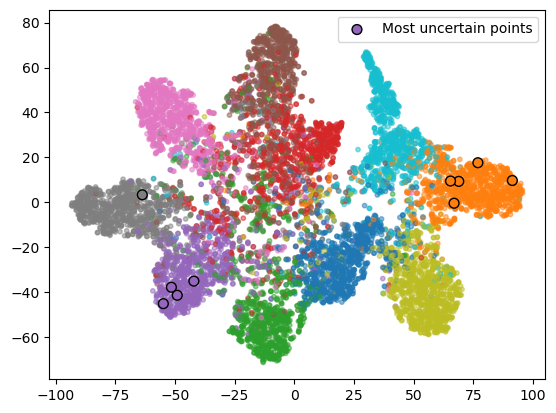

In [10]:
plot_client_features(embeddings_2d, labels, score_idx)